### Time-series Anomaly Detection by PCA

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from library.PCA import PCA

%load_ext autoreload
%autoreload 2

### Load & Pre-processing Data

In [2]:
# load data
path = './dataset/TE2001/'

train = np.zeros((22, 480, 52))
test = np.zeros((22, 960, 52))

for i in range(0, 22): 
    # load train data
    file_name = 'd' + str(i).zfill(2) + '.dat'
    
    if i == 0: # exception
        tmp = np.loadtxt(path + file_name)
        train[i, :, :] = tmp.T[:480, :]
    else:
        train[i, :, :] = np.loadtxt(path + file_name)
    
    # load test data
    file_name = 'd' + str(i).zfill(2) + '_te.dat'
    test[i, :, :] = np.loadtxt(path + file_name)
    
print('train size :', train.shape)
print('test size :', test.shape)

train size : (22, 480, 52)
test size : (22, 960, 52)


논문에서 사용한 센서 XMEAS(1-22), XMV(1-11)만 추출하여 계산합니다.

In [3]:
# choose variables - XMEAS(1-22), XMV(1-11)
idx = np.hstack((np.arange(22), np.arange(41, 52)))
train = train[:, :, idx]
test = test[:, :, idx]

print('train size :', train.shape)
print('test size :', test.shape)

train size : (22, 480, 33)
test size : (22, 960, 33)


Train set과 test set을 normalize합니다. 정상 데이터로만 학습시키기 위해 train set의 0번을 사용합니다.

In [4]:
# train mean and validation
X = train[0]
mean = np.mean(X, axis=0)
std = np.std(X, axis=0)

# normalization
x_train = (X - mean) / std
x_test = (test - mean) / std

print('x_train size :', x_train.shape)
print('x_test size :', x_test.shape)

x_train size : (480, 33)
x_test size : (22, 960, 33)


### PCA
PCA class를 선언하고 train set에 대해 학습을 진행합니다.
- num_comp : PCA 계산에 사용될 주성분 갯수입니다.
- alpha_tsq : T^2는 PCA의 주성분으로 투영된 공간에서 중심으로부터의 거리를 나타냅니다. 이 때 alpha는 거리 분포에서 어디까지 정상으로 판단할 것인지 설정하는 값입니다.
- alpha_spe : SPE는 PCA의 나머지 성분으로 투영된 공간에서의 에러를 나타냅니다. 이 때 alpha는 에러 분포에서 어디까지 정상으로 판단할 것인지 설정하는 값입니다.

In [5]:
pca = PCA(num_comp=10, alpha_tsq=0.99, alpha_spe=0.99)
Tsq_thres, SPE_thres = pca.fit(x_train)

Cumsum of variance : 0.9004617673220161
It takes 0.005 sec for training model


Test set의 1번 fault에 대한 예측을 진행합니다.

In [6]:
Tsq, SPE = pca.predict(x_test[1])

결과를 visualize합니다.

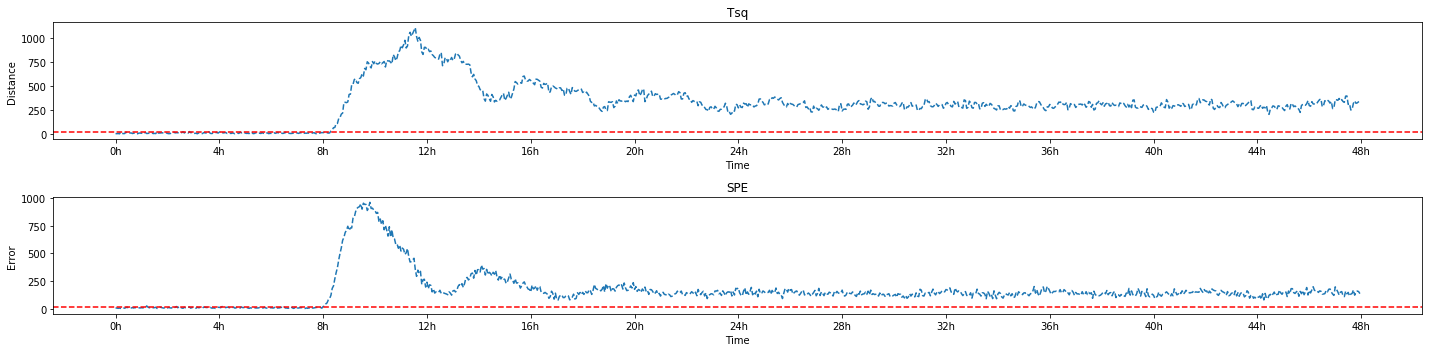

In [7]:
# Tsq
plt.figure(figsize=(20, 5))
plt.subplot(2, 1, 1)
plt.plot(Tsq, linestyle='--')
plt.title('Tsq')
plt.xlabel('Time')
plt.ylabel('Distance')
plt.xticks(np.arange(0, 980, 80), [str(x) + 'h' for x in np.arange(0, 49, 4)])
plt.axhline(y=Tsq_thres, color='r', linestyle='--')

# SPE
plt.subplot(2, 1, 2)
plt.plot(SPE, linestyle='--')
plt.title('SPE')
plt.xlabel('Time')
plt.ylabel('Error')
plt.xticks(np.arange(0, 980, 80), [str(x) + 'h' for x in np.arange(0, 49, 4)])
plt.axhline(y=SPE_thres, color='r', linestyle='--')

plt.tight_layout()
plt.show()

논문에서는 보통 (Tsq > threshold) or (SPE > threshold)일 때 anomaly로 분류합니다.